In [65]:
from IPython.display import HTML
HTML('''<script>
var code_show_err = false; 
var code_toggle_err = function() {
 var stderrNodes = document.querySelectorAll('[data-mime-type="application/vnd.jupyter.stderr"]')
 var stderr = Array.from(stderrNodes)
 if (code_show_err){
     stderr.forEach(ele => ele.style.display = 'block');
 } else {
     stderr.forEach(ele => ele.style.display = 'none');
 }
 code_show_err = !code_show_err
} 
document.addEventListener('DOMContentLoaded', code_toggle_err);
</script>
To toggle on/off warnings, click <a onclick="javascript:code_toggle_err()">here</a>.''')

## Preamble

In this notebook we'll look to do the following:
* Get TFL Station location data (point data).
* Get London borough shapefiles (polygon data)
* Plot the data on a map.
    * Try various visualisation options.
* Generate 1000 random locations in London.
* Calculate the distance between those random locations and their nearest TFL station at scale, using `kdtrees`.
* Explore the use of voronoi diagrams to acheive a similar result.

During the project we should cover the following.
* Loading location data into `geopandas`.
* Data Visualisation.
* Spatial Joins.
* Nearest neighbour calculations with `kdtrees`.
* Creating voronoi diagrams.

## Import packages

Firstly we'll import some necessary packages in order to get started.

* `Geopandas` is a Python package which allows us access to tabular data structures with some very helpful geospatial methods. 
* `hvplot` is visulisation package which provides a pandas-like API and `bokeh`-like plotting, it also works well with geospatial visualisations via calls to the `geoviews` package.
* `pandas` for the creation of tabular data structures.

In [66]:
import geopandas as gp
import hvplot as hv
import hvplot.pandas
import numpy as np
import pandas as pd

In [67]:
pd.set_option('display.max_rows', 50)

## Data Gathering

Firstly, we'll get data in London for each TFL station.

In [68]:
import geopandas as gp
gp.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'

tfl_stations = gp.read_file('data/stations.kml', driver='KML')
tfl_stations.geometry = gp.points_from_xy(tfl_stations.geometry.x, tfl_stations.geometry.y)

Now we have a table of stations in London with their names, a brief description, and their geometries.

In [69]:
tfl_stations.head()

,Name,Description,geometry
0,Acton Town Station,"Acton Town Station, London Underground Ltd., G...",POINT (-0.28025 51.50275)
1,Aldgate Station,"Aldgate Station, London Underground Ltd., Aldg...",POINT (-0.07561 51.51427)
2,Aldgate East Station,"Aldgate East Station, London Underground Ltd.,...",POINT (-0.07229 51.51523)
3,Alperton Station,"Alperton Station, London Underground Ltd., Eal...",POINT (-0.29949 51.54069)
4,Amersham Station,"Amersham Station, Stn Approach, Amersham, Buck...",POINT (-0.60748 51.67415)


Let's inspect the geometry co-ordinate reference system.

In [70]:
tfl_stations.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

## Data Visualisation

Let's plot the data on to a map, along with the `Name` of the station in the hover tool. <br>
We're using an `x` marker to differentiate them from the other points we'll be plotting.

In [71]:
tfl_stations_plot = tfl_stations.hvplot(geo=True,
                                        title='TFL Stations',
                                        marker='x',
                                        color='red',
                                        size=20,
                                        tiles='CartoLight', 
                                        hover_cols=["Name"]
                                       )
tfl_stations_plot

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]   (Name)

Now we'll get locations of some other places in London, we'll be generating 1000 points at random.

To do this, let's first get the total bounds of the polygon. <br>
We're doing so because we're only interested in random points within the total area all of the TFL stations. <br>
We don't want a random point in the North Sea!


This will tell us the most `West`, `South`, `East` and `North` points respectively.

In [72]:
tfl_stations.total_bounds

array([-0.61121925, 51.40233694,  0.25108712, 51.70503045])

Now let's convert that into a polygon to get the total area covered by all the TFL stations. <br>
We can do this by using `unary_union` to bring all the points together, followed by `convex_hull` to convert the set of points to a polygon.

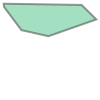

In [73]:
tfl_polygon = tfl_stations.unary_union.convex_hull
tfl_polygon

Now let's convert this Polygon to a `GeoDataFrame` by using the `GeoDataFrame` constructor.

In [74]:
area_df = gp.GeoDataFrame(
    pd.DataFrame([tfl_polygon], columns=['geometry']), 
    geometry='geometry', 
    crs=tfl_stations.crs)

We can now plot this below, I've set the transparancy to `0.1` so we can still see the tiles below.

In [75]:
area_df_plot = area_df.hvplot(geo=True, tiles='CartoLight', alpha = 0.1, c='yellow')
area_df_plot.opts(title='TFL Station footprint')

:Overlay
   .Tiles.I    :Tiles   [x,y]
   .Polygons.I :Polygons   [Longitude,Latitude]

We can also easily plot both the stations and the convex area on one plot by using the `*` operator.

However, we need to be sure that the tiles are only defined in one of the two plots, otherwise they'll overlap and we won't be able to see the stations.

We can do this by accessing the `.Polygons` attribute of the plot we just did above, this means the `.Tiles` element of the plot is ignored.

In [76]:
(tfl_stations_plot * area_df_plot.Polygons).opts(title='TFL Stations with their total footprint')

:Overlay
   .Tiles.I  :Tiles   [x,y]
   .Points.I :Points   [Longitude,Latitude]   (Name)
   .I.I      :Polygons   [Longitude,Latitude]

Next we'll create 1000 random points within this polygon to calculate Neighest Neighbours. <br>
The function below: `random_point_in_shp` will select a random point within a polygon. <br>
This function was helpfully found and adapted from [here](https://stackoverflow.com/questions/58802921/using-geopandas-how-to-randomly-select-in-each-polygon-5-points-by-sampling-met).

In [77]:
from shapely.geometry import Point
def random_point_in_shp(shp):
    within = False
    while not within:
        x = np.random.uniform(shp.bounds[0], shp.bounds[2])
        y = np.random.uniform(shp.bounds[1], shp.bounds[3])
        within = shp.contains(Point(x, y))
    return Point(x, y)

In [78]:
list_of_random_points = [random_point_in_shp(tfl_polygon) for _ in range(1000)]

Now we have a list of random points within the polygon, let's turn this into a `GeoDataFrame` and plot along with the other objects.

In [79]:
random_points_in_ldn = gp.GeoDataFrame(list_of_random_points, columns=['geometry'])
random_points_in_ldn.crs = "EPSG:4326"
random_points_in_ldn.name = 'Random Points in London'

Let's have a look at some of these random points.

In [80]:
random_points_in_ldn.head()

,geometry
0,POINT (-0.26675 51.64358)
1,POINT (-0.16769 51.66310)
2,POINT (-0.34660 51.57551)
3,POINT (-0.41923 51.54319)
4,POINT (-0.45444 51.67667)


## Spatial Join

So now we have the following dataframes:
* `tfl_stations`
* `area_df`
* `random_points_in_ldn`

But let's say we want to find out which area each random point is in. <br>
Fear not, we're not going to do this by hand. <br>
Instead we'll do a spatial join, where we'll take:
1. A shapefile with the boundaries of all areas in the UK
1. The random points 

We'll do a spatial join between the points and the boundaries, this will tell us which boundary each point is within.

First let's get boundary data for the UK at a Local Authority District level. <br>
Luckily, geopandas allows us to read in data from the internet directly, we simply need to supply the correct url, which we can get from the [ONS Geography](https://geoportal.statistics.gov.uk/datasets/local-authority-districts-december-2019-boundaries-uk-bfe-1/geoservice) website, which is a brilliant resource for UK Geospatial data.

In [81]:
lad_name = 'LAD20NM'
lad_id = 'LAD20CD'

In [82]:
lad_url = 'https://opendata.arcgis.com/datasets/5c71e19f21024007b6ce54ef47bb51b1_0.geojson'
lad_shapes = gp.read_file(lad_url, geometry='geometry')

In [83]:
lad_shapes.head()

,OBJECTID,LAD20CD,LAD20NM,LAD20NMW,BNG_E,BNG_N,LONG,LAT,Shape__Area,Shape__Length,geometry
0,1,E06000001,Hartlepool,,447160,531474,-1.27018,54.676140,9.834667e+07,66121.472650,"POLYGON ((-1.26846 54.72612, -1.26822 54.72609..."
1,2,E06000002,Middlesbrough,,451141,516887,-1.21099,54.544670,5.455359e+07,41055.809886,"POLYGON ((-1.25112 54.59153, -1.24953 54.59151..."
2,3,E06000003,Redcar and Cleveland,,464361,519597,-1.00608,54.567520,2.537854e+08,105292.138896,"POLYGON ((-1.14105 54.64773, -1.13798 54.64737..."
3,4,E06000004,Stockton-on-Tees,,444940,518183,-1.30664,54.556911,2.097308e+08,108085.255484,"POLYGON ((-1.31729 54.64480, -1.31715 54.64480..."
4,5,E06000005,Darlington,,428029,515648,-1.56835,54.535339,1.974757e+08,107206.401677,"POLYGON ((-1.63768 54.61714, -1.63767 54.61670..."


Let's plot these shapes to see what this looks like.

In [84]:
lad_shapes_plot = lad_shapes.hvplot(geo=True, alpha = 0.3,  crs=lad_shapes.crs.to_json(), hover_cols=[lad_name])

Let's look at `lad_shapes`, notice the lad_name which has the name of the area and the `geometry` column which has the the Polygon objects.

In [85]:
random_points_in_ldn.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [86]:
lad_shapes.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

Now we'll do the spatial join, just like any other join we declare the two objects we're joining together: `random_points_in_ldn` and `lad_shapes`. We then state the `how`, and we also state `op="within"` to show we want the join to occur when one point is _within_ the boundary.

In [87]:
random_points_in_ldn_lad = gp.sjoin(random_points_in_ldn, lad_shapes, how="left", op='within')

Let's look at this new dataframe, we should see that for each random point in london that we created we see the associated area in the `lad_name` column.

In [88]:
random_points_in_ldn_lad.head()

,geometry,index_right,OBJECTID,LAD20CD,LAD20NM,LAD20NMW,BNG_E,BNG_N,LONG,LAT,Shape__Area,Shape__Length
0,POINT (-0.26675 51.64358),283,284,E09000003,Barnet,,523473,191752,-0.21819,51.611069,8.676670e+07,50937.778177
1,POINT (-0.16769 51.66310),290,291,E09000010,Enfield,,532831,196198,-0.08144,51.648891,8.219033e+07,41091.477198
2,POINT (-0.34660 51.57551),295,296,E09000015,Harrow,,515359,189736,-0.33598,51.594669,5.046427e+07,33811.791286
3,POINT (-0.41923 51.54319),297,298,E09000017,Hillingdon,,508166,183121,-0.44182,51.536640,1.157044e+08,63941.217702
4,POINT (-0.45444 51.67667),122,123,E07000102,Three Rivers,,507313,196418,-0.45005,51.656319,8.882417e+07,74112.632398


Let's add a simple deccription column for each random point. <br>
For each row, this column will say:
* what area the random point was in
* the random point rank in that area i.e. Random point 1, 2, 3 etc.

We'll put this together with a list comprehension and an f-string.

In [89]:
random_point_number = random_points_in_ldn_lad\
.groupby(lad_name)['OBJECTID'].transform(lambda x: x.rank(method='first')).astype(str)

random_points_in_ldn_lad['random_point_desc'] = \
[f"Random point in {row[lad_name]}: {random_point_number.loc[index]}" 
 for index, row in random_points_in_ldn_lad.iterrows()] 

Let's sort the dataframe and have a look at it, including the `random_point_desc` column at the end.

In [90]:
random_points_in_ldn_lad = random_points_in_ldn_lad.sort_values([lad_name, 'random_point_desc'])
random_points_in_ldn_lad

,geometry,index_right,OBJECTID,LAD20CD,LAD20NM,LAD20NMW,BNG_E,BNG_N,LONG,LAT,Shape__Area,Shape__Length,random_point_desc
53,POINT (0.13319 51.52109),282,283,E09000002,Barking and Dagenham,,547757,185111,0.129479,51.545551,3.778184e+07,37093.086286,Random point in Barking and Dagenham: 1.0
313,POINT (0.10218 51.52383),282,283,E09000002,Barking and Dagenham,,547757,185111,0.129479,51.545551,3.778184e+07,37093.086286,Random point in Barking and Dagenham: 10.0
317,POINT (0.14171 51.59156),282,283,E09000002,Barking and Dagenham,,547757,185111,0.129479,51.545551,3.778184e+07,37093.086286,Random point in Barking and Dagenham: 11.0
441,POINT (0.13358 51.55124),282,283,E09000002,Barking and Dagenham,,547757,185111,0.129479,51.545551,3.778184e+07,37093.086286,Random point in Barking and Dagenham: 12.0
446,POINT (0.09405 51.54554),282,283,E09000002,Barking and Dagenham,,547757,185111,0.129479,51.545551,3.778184e+07,37093.086286,Random point in Barking and Dagenham: 13.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,POINT (-0.19869 51.51529),313,314,E09000033,Westminster,,528268,180871,-0.152950,51.512211,2.203779e+07,27258.565014,Random point in Westminster: 5.0
328,POINT (-0.18007 51.53943),313,314,E09000033,Westminster,,528268,180871,-0.152950,51.512211,2.203779e+07,27258.565014,Random point in Westminster: 6.0
383,POINT (-0.12222 51.51195),313,314,E09000033,Westminster,,528268,180871,-0.152950,51.512211,2.203779e+07,27258.565014,Random point in Westminster: 7.0
443,POINT (-0.17011 51.53783),313,314,E09000033,Westminster,,528268,180871,-0.152950,51.512211,2.203779e+07,27258.565014,Random point in Westminster: 8.0


## Section Recap

Let's plot everything we've done, to recap we now have data for the following:
* `tfl_stations` in London and Greater London. 
    * Plotted above as `tfl_stations_plot`.
* `area_df` - the convex hull of the area captured by these tfl_stations.
    * Plotted above as `area_df_plot`.
* `lad_shapes` - Shapefiles for the whole of the UK at Local Authority District level.
    * Plotted above as `lad_shapes_plot`.
* `random_points_in_ldn_lad` - 1000 random points in London we've generated, along with the area each point is in.
    * We'll plot this as `random_points_in_ldn_lad_plot` below.
    
As we're only concerned with London for this analysis, I'll filter the `lad_shapes` to only cover areas with a random point inside them, to create `ldn_lad_shapes`.

In [91]:
random_points_in_ldn_lad.head()

,geometry,index_right,OBJECTID,LAD20CD,LAD20NM,LAD20NMW,BNG_E,BNG_N,LONG,LAT,Shape__Area,Shape__Length,random_point_desc
53,POINT (0.13319 51.52109),282,283,E09000002,Barking and Dagenham,,547757,185111,0.129479,51.545551,3.778184e+07,37093.086286,Random point in Barking and Dagenham: 1.0
313,POINT (0.10218 51.52383),282,283,E09000002,Barking and Dagenham,,547757,185111,0.129479,51.545551,3.778184e+07,37093.086286,Random point in Barking and Dagenham: 10.0
317,POINT (0.14171 51.59156),282,283,E09000002,Barking and Dagenham,,547757,185111,0.129479,51.545551,3.778184e+07,37093.086286,Random point in Barking and Dagenham: 11.0
441,POINT (0.13358 51.55124),282,283,E09000002,Barking and Dagenham,,547757,185111,0.129479,51.545551,3.778184e+07,37093.086286,Random point in Barking and Dagenham: 12.0
446,POINT (0.09405 51.54554),282,283,E09000002,Barking and Dagenham,,547757,185111,0.129479,51.545551,3.778184e+07,37093.086286,Random point in Barking and Dagenham: 13.0


In [92]:
ldn_lad_shapes = lad_shapes[lad_shapes[lad_id].isin(random_points_in_ldn_lad[lad_id].unique())]

In [93]:
ldn_lad_shapes = ldn_lad_shapes.to_crs(epsg=27700)

In [94]:
ldn_lad_shapes.crs

<Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: United Kingdom (UK) - offshore to boundary of UKCS within 49°45'N to 61°N and 9°W to 2°E; onshore Great Britain (England, Wales and Scotland). Isle of Man onshore.
- bounds: (-9.0, 49.75, 2.01, 61.01)
Coordinate Operation:
- name: British National Grid
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

In [95]:
ldn_lad_shapes_plot = ldn_lad_shapes.hvplot(
    crs = 'EPSG: 27700',
    alpha=0.3,
    hover_cols=[lad_id],
    cmap='glasbey_dark')

In [96]:
random_points_in_ldn_lad_plot = random_points_in_ldn_lad.hvplot(geo=True, s=3, hover_cols = ['random_point_desc'])

In [97]:
ldn_lad_shapes.head()

,OBJECTID,LAD20CD,LAD20NM,LAD20NMW,BNG_E,BNG_N,LONG,LAT,Shape__Area,Shape__Length,geometry
56,57,E06000060,Buckinghamshire,,482506,208561,-0.805690,51.769661,1.564949e+09,361853.598103,"POLYGON ((472045.415 242897.104, 472048.012 24..."
95,96,E07000072,Epping Forest,,548919,203758,0.154147,51.712791,3.389841e+08,123273.197785,"POLYGON ((549942.616 215785.905, 549968.110 21..."
118,119,E07000095,Broxbourne,,534742,204251,-0.050730,51.720798,5.144230e+07,39068.745794,"POLYGON ((537127.516 210970.204, 537127.714 21..."
119,120,E07000096,Dacorum,,500084,208745,-0.550980,51.768452,2.124764e+08,110103.830872,"POLYGON ((505599.713 218260.807, 505619.212 21..."
120,121,E07000098,Hertsmere,,519774,199352,-0.268990,51.680168,1.011282e+08,61228.163849,"POLYGON ((520196.010 205463.198, 520218.412 20..."


Let's plot all the artefacts we've created thus far on a single plot. <br>
We would normally split this much information out with mutliple plots with a shared axis, but I'd like to show that plot aggregation is possible and intuitive.

In [98]:
big_plot = tfl_stations_plot * ldn_lad_shapes_plot * area_df_plot.Polygons * random_points_in_ldn_lad_plot
(big_plot).opts(
    frame_width= 900,
    frame_height= 1000,
    title_format='Various geospatial artefacts',
    xlim=(-20000, -17000),
    ylim=(6650000, 6800000)
)

:Overlay
   .Tiles.I    :Tiles   [x,y]
   .Points.I   :Points   [Longitude,Latitude]   (Name)
   .Polygons.I :Polygons   [Longitude,Latitude]   (LAD20CD)
   .I.I        :Polygons   [Longitude,Latitude]
   .Points.II  :Points   [Longitude,Latitude]   (random_point_desc)

## Nearest Neighbours

You may be thinking, why did we create 1000 random points earlier, well now all is to be revealed.

Let's say we want to find the nearest tube station to everyone one of those 1000 random points. <br>
How would we do it? <br>
Remember, we have 1000 random points, and 302 stations. <br>
We could probably do a nested for loop...<br>
where, for each random point: we calculate its distance to each of the 302 stations, and then select the station with the smallest distance.

Now, whilst that might work, this approach requires `1000 x 302 == 302,000` distance calculations. <br>
It'll take some time, and how will it scale if we increase the number of points, to 10,000, or maybe a million. <br>
The answer is, not very well. 

This algorithm can be said to scale in time complexity with n<sup>2</sup>. <br>
The following section will show, that by storing our geospatial data in a binary search tree, rather than an array, we can speed up this process dramatically, such that time complexity scaled with the following relationship $O(D·N·logN)$.

Firstly, we'll change the co-ordinate reference system of our points so they are on a rectilinear geography. <br>
The algorithm we'll be using operates with euclidean distance so we need a flat plane rather than a curved plane.

This will require our data to be converted to a crs of``EPSG: 27700``, this is the rectilinear geometry for the UK.

In [99]:
tfl_stations = tfl_stations.to_crs(epsg = 27700)

In [100]:
random_points_in_ldn_lad = random_points_in_ldn_lad[[lad_name, 'random_point_desc', 'geometry']].to_crs(epsg = 27700)

Below we'll create a function to help us calculate the nearest neighbours.

In [101]:
import numpy as np
from scipy.spatial import KDTree

In [102]:
def kdtreenearest(gdfA, gdfB):
    assert gdfA.crs.to_epsg() == gdfB.crs.to_epsg() == 27700, "Check crs."
    # Take a copy of both DataFrames
    gdfA, gdfB = gdfA.copy().reset_index(), gdfB.reset_index(drop=True)
    # Convert geometries to nested list of lists
    nA = np.array(list(zip(gdfA.geometry.x, gdfA.geometry.y)))
    nB = np.array(list(zip(gdfB.geometry.x, gdfB.geometry.y)))
    # Create kdtree object
    btree = KDTree(nB)
    # Query the tree for the nearest neigbour (k-1) with a euclidean geometry (p=2)
    dist, idx = btree.query(nA, k=1, p=2)
    # Create a list of data to concatenate, notice we ahd to reset_index the index above so the concanetation occurs on position
    # this is because when we converted our geometries to arrays, we lost row index information
    concat_list = [gdfA, 
                   gdfB.iloc[idx, :].loc[:, (gdfB.columns != 'geometry')].reset_index(drop=True),
                   pd.Series(dist, name='distance')]
    # Create the final dataframe, then add the original index of gdfA
    gdf = pd.concat(concat_list, axis=1, join='inner').set_index('index', drop=True)
    
    # Return a tuple of: the dataframe of interest, the list or raw distances, and the assocated indices of gdfB nearest neighbours
    return gdf, dist, idx

In [103]:
kdtree_results, raw_distances, idx = kdtreenearest(random_points_in_ldn_lad, tfl_stations)

That was quick!

Let's look at the results...

In [104]:
kdtree_results.head()

,LAD20NM,random_point_desc,geometry,Name,Description,distance
index,,,,,,
53,Barking and Dagenham,Random point in Barking and Dagenham: 1.0,POINT (548093.656 182397.870),Becontree Station,"Becontree Station, London Underground Ltd., Ga...",2173.244143
313,Barking and Dagenham,Random point in Barking and Dagenham: 10.0,POINT (545933.768 182639.919),Upney Station,"Upney Station, London Underground Ltd., Upney ...",1614.597891
317,Barking and Dagenham,Random point in Barking and Dagenham: 11.0,POINT (548455.297 190250.853),Fairlop Station,"Fairlop Station, London Underground Ltd., Fore...",3548.498979
441,Barking and Dagenham,Random point in Barking and Dagenham: 12.0,POINT (548023.146 185751.317),Becontree Station,"Becontree Station, London Underground Ltd., Ga...",1291.579649
446,Barking and Dagenham,Random point in Barking and Dagenham: 13.0,POINT (545300.364 185038.673),Upney Station,"Upney Station, London Underground Ltd., Upney ...",956.593443


The sample above looks to be correct, we can verify with the map we created earlier.

## Voronoi Diagrams

A Voronoi diagram is a way of partitioning a plane of points. <br>
For each point _p_ there is an associated voronoi region _R_ such that all points in R have _p_ as their closest point.

We can use voronoi diagrams to tesselate a space, this can help us answer the following question:
* For what region is Bank Station the closest possible station.

In the section above we did something similar with random points we created, with voronoi diagrams we can get straight to the region.

Let's import the necessary functions from `scipy.spatial`.

In [105]:
from scipy.spatial import Voronoi, voronoi_plot_2d

Let's convert the TFL station geometries into a nested list so `scipy` can understand them. <br>
**Remember**: These geometries must be rectilinear.

In [106]:
nA = np.array(list(zip(tfl_stations.geometry.x, tfl_stations.geometry.y))) 

This is what `tfl_stations` looks like.

In [107]:
tfl_stations.head()

,Name,Description,geometry
0,Acton Town Station,"Acton Town Station, London Underground Ltd., G...",POINT (519459.853 179603.230)
1,Aldgate Station,"Aldgate Station, London Underground Ltd., Aldg...",POINT (533628.279 181237.984)
2,Aldgate East Station,"Aldgate East Station, London Underground Ltd.,...",POINT (533856.302 181350.995)
3,Alperton Station,"Alperton Station, London Underground Ltd., Eal...",POINT (518026.758 183791.694)
4,Amersham Station,"Amersham Station, Stn Approach, Amersham, Buck...",POINT (496385.697 198181.627)


Let's construct the voronoi diagram with the `Voronoi` class.

In [108]:
tfl_vor = Voronoi(nA)

Now let's plot the regions with a simple matplotlib plot.

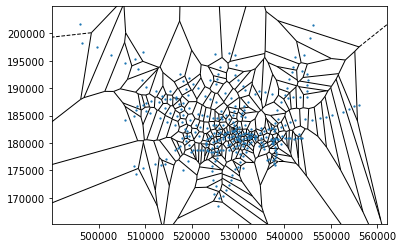

In [109]:
tfl_vor_simple_plot = voronoi_plot_2d(tfl_vor, show_vertices=False, point_size=2.5)

All looks good, but let's see if we can plot it interactively with `hvplot` just as we did earlier.

Each Voronoi object contains an attribute called `.ridge_vertices` which contains ["Indices of the Voronoi vertices forming each Voronoi ridge."](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.spatial.Voronoi.html)

We can use these in to create a nested list (`lines`) in which each outer list contains all the lines associated with one voroni ridge.

In [110]:
import shapely
lines = \
[shapely.geometry.LineString(tfl_vor.vertices[line])for line in tfl_vor.ridge_vertices if -1 not in line]

Now we can create polygons for each voronoi region.

In [111]:
shapely_voronoi_polygons = shapely.ops.polygonize(lines)

Now we can create a `GeoDataFrame` of these voronoi polygons.

In [112]:
voronoi_polygons = gp.GeoDataFrame(shapely_voronoi_polygons, geometry = 'geometry', columns=['geometry'], crs="EPSG:27700")
voronoi_polygons.head()

,geometry
0,"POLYGON ((538612.983 202297.832, 556085.003 19..."
1,"POLYGON ((536038.156 203989.737, 538612.983 20..."
2,"POLYGON ((521201.665 255848.165, 523271.165 24..."
3,"POLYGON ((523271.165 247654.059, 533759.623 21..."
4,"POLYGON ((533759.623 210866.549, 536038.156 20..."


Now we can do a spatial join between the stations and the voronoi polygons so we can associate each voronoi polygon with its station.

In [113]:
tfl_voronoi = gp.sjoin(tfl_stations[['Name', 'geometry']], voronoi_polygons, how='right', op='within').drop(columns=['index_left'])

Now let's create a plot for the voronoi regions.

In [114]:
tfl_voronoi_plot = tfl_voronoi.hvplot(
    geo=True,
    crs='EPSG: 27700',
    alpha=0.1
)

In [115]:
(tfl_stations_plot * tfl_voronoi_plot)\
.opts(frame_height=500,
      frame_width=800,
      title_format='TFL stations and their voronoi regions',
    xlim=(-20000, -17000),
    ylim=(6650000, 6800000)
)

:Overlay
   .Tiles.I    :Tiles   [x,y]
   .Points.I   :Points   [Longitude,Latitude]   (Name)
   .Polygons.I :Polygons   [Longitude,Latitude]

As you can see above we have a problem... <br>
The algorithm behind the voronoi regions can sometimes lead to boundaries stretching to infinity. <br>
So from what we've learnt above, what's the common sense thing to do? <br>
Let's try and clip the voronoi regions, such at they cannot _grow_ past the convex hull of all TFL stations. This should stop Lewisham from expanding half way across the world!

First we'll copy the dataframe above.

In [116]:
tfl_voronoi_clipped = tfl_voronoi.copy().set_geometry('geometry')
tfl_polygon_df = gp.GeoDataFrame(pd.Series(tfl_polygon, name='geometry'), crs="EPSG:4326").to_crs('EPSG:27700')


Next we'll use the geopandas `overlay` function to clip the voronoi polyons, notice the `how='intersection'`.

In [117]:
tfl_voronoi_clipped = gp.overlay(tfl_voronoi_clipped, tfl_polygon_df, how='intersection')

In [118]:
tfl_voronoi_clipped_plot = tfl_voronoi_clipped.hvplot(
    geo=True,
    crs='EPSG: 27700',
    alpha=0.1
)

Now let's plot the results.

In [119]:
(tfl_stations_plot * tfl_voronoi_clipped_plot)\
.opts(frame_height=500,
      frame_width=800,
      title_format='TFL stations and their clipped voronoi regions',
    xlim=(-20000, -17000),
    ylim=(6650000, 6800000)
)

:Overlay
   .Tiles.I    :Tiles   [x,y]
   .Points.I   :Points   [Longitude,Latitude]   (Name)
   .Polygons.I :Polygons   [Longitude,Latitude]

So now we've clipped the voronoi regions to the convex hull of the stations.

This is a way to deal with the edge voronoi regions bounding to infinity, as was the case in Lewisham.

Finally, we'll compare the area of each voronoi region.

In [120]:
tfl_voronoi_clipped['Area (m²)'] = tfl_voronoi_clipped.geometry.area

In [121]:
tfl_voronoi_clipped[['Name', 'Area (m²)']].sort_values('Area (m²)').iloc[0:15,]\
.hvplot(title = "TFL Stations with the smallest voronoi regions", kind ='bar', geo=False, x="Name", y="Area (m²)",  rot=60)

:Bars   [Name]   (Area (m²))

In [122]:
tfl_voronoi_clipped[['Name', 'Area (m²)']].sort_values('Area (m²)').iloc[-15:,]\
.hvplot(title = "TFL Stations with the largest voronoi regions", kind ='bar', geo=False, x="Name", y="Area (m²)",  rot=60)

:Bars   [Name]   (Area (m²))

As we'd expect, central London stations are more tightly packed in, leading to smaller regions. Remote stattions such has Watford have larger regions.

## Challenge

If you'd like a challenge of your own, see if you can find the median voronoi region area per London borough and plot it as a bar chart below! <br>
As an extra challenge, see if you can repeat the analysis, including National Rail station locations.

There we have it, we've plotted voronoi diagrams, explored kdtrees, looked at geopandas for geospatial transformations, and done some interactive mapping visualisations. <br>
I've left some useful links below.

### Useful Links
* [Geopandas](https://geopandas.org/)
* [hvplot - Geographic Data](https://hvplot.holoviz.org/user_guide/Geographic_Data.html)
* [shapely](https://shapely.readthedocs.io/en/latest/manual.html)